In [1]:
import sys
from pathlib import Path
import os
import pandas as pd

# CERNBOX = os.environ["CERNBOX"]
REPO_PATH = Path.home() / "workspace/jetpointnet"
# SCRIPT_PATH = REPO_PATH / "python_scripts/data_processing/jets"
SCRIPT_PATH = REPO_PATH / "python_scripts"
sys.path.append(str(SCRIPT_PATH))

os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Set GPU - Must be done before importing tf

# from particle import Particle can I get??
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import math
import time
import awkward as ak
import pyarrow.parquet as pq
from tqdm.auto import tqdm
from jets_training.models.JetPointNet import (
    PointNetSegmentation,
    masked_weighted_bce_loss,
    masked_regular_accuracy,
    masked_weighted_accuracy,
)
from data_processing.jets.preprocessing_header import NPZ_SAVE_LOC

RESULTS_PATH = REPO_PATH / "results"
RESULTS_PATH.mkdir(exist_ok=True)
MODELS_PATH = REPO_PATH / "models"
MODELS_PATH.mkdir(exist_ok=True)

MAX_SAMPLE_LENGTH = 278
BATCH_SIZE = 240 # half of 480 - orginal
EPOCHS = 10 # back to marco's settings
TRAIN_DIR = NPZ_SAVE_LOC / "train"
VAL_DIR = NPZ_SAVE_LOC / "val"

model = PointNetSegmentation(MAX_SAMPLE_LENGTH, 1)

model.load_weights("/home/jhimmens/workspace/jetpointnet/models/2000_events_w_fixed_hits/raw/PointNet_last_epoch=99.keras")


2024-06-03 19:35:50.022766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 19:35:50.074016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 19:35:50.074053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 19:35:50.075522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 19:35:50.083564: I tensorflow/core/platform/cpu_feature_guar

TypeError: PointNetSegmentation() missing 1 required positional argument: 'num_classes'

In [3]:
# load test data
def load_data_from_npz_old(npz_file):
    data = np.load(npz_file)
    feats = data["feats"][:, :MAX_SAMPLE_LENGTH, 1:]  # discard eventNumber
    frac_labels = data["frac_labels"][:, :MAX_SAMPLE_LENGTH]
    energy_weights = data["tot_truth_e"][:, :MAX_SAMPLE_LENGTH]
    return feats, frac_labels, energy_weights

def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats'][:, :MAX_SAMPLE_LENGTH, 1:]  # Shape: (num_samples, 859, 6)
    frac_labels = data['frac_labels'][:, :MAX_SAMPLE_LENGTH]  # Shape: (num_samples, 859)
    tot_labels = data['tot_labels'][:, :MAX_SAMPLE_LENGTH]  # Shape: (num_samples, 859)
    tot_truth_e = data['tot_truth_e'][:, :MAX_SAMPLE_LENGTH]  # Shape: (num_samples, 859) (This is the true total energy deposited by particles into this cell)
    return feats, frac_labels, tot_labels, tot_truth_e

filename_npz = "/home/jhimmens/workspace/jetpointnet/pnet_data/processed_files/2000_events_w_fixed_hits/raw/SavedNpz/deltaR=0.1/energy_scale=1000/test/chunk_0_test.npz"
feats, frac_labels, tot_labels, tot_truth_e = load_data_from_npz(filename_npz)
x, y, weight = feats, frac_labels, tot_truth_e # this just uses the first event

In [4]:
print(len(x))
# convert y to pandas
print(y)
y_pd = pd.DataFrame(y)
y_pd

529
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


,0,1,2,3,4,5,6,7,8,9,...,268,269,270,271,272,273,274,275,276,277
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
525,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
526,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
527,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [5]:
segmentation_logits = model.predict(x)
segmentation_logits = np.squeeze(segmentation_logits, axis=-1)
print(len(segmentation_logits[1]))
# print(segmentation_logits[0]) # predictions from 1st events
# [print(i) for i in segmentation_logits[1]]
# all non-0 bar,


sample_idx = 0
sample_features = feats[sample_idx]
energies = tot_labels[sample_idx]
fracs = frac_labels[sample_idx]
tot_true_energy = tot_truth_e[sample_idx]
print(dir(fracs))
print(fracs.shape)

energy_point_indices = sample_features[:, 6] == 1

predicted_classes = np.where(segmentation_logits[sample_idx] > 0, 1, 0) # changed to greater than 0.5
true_classes = np.where(frac_labels[sample_idx] > 0.5, 1, 0)

energies_filtered = tot_truth_e[sample_idx][energy_point_indices]
predicted_classes_filtered = predicted_classes[energy_point_indices]
filtered_predicted_raw = segmentation_logits[sample_idx][energy_point_indices]
true_classes_filtered = true_classes[energy_point_indices]

# find truth energies
tot_truth_e

17/17 [==============================] - 2s 69ms/step
278
['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow_

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [ ]:
ak_file = "/home/jhimmens/workspace/jetpointnet/pnet_data/processed_files/2000_events_w_fixed_hits/AwkwardArrs/deltaR=0.1/test/chunk_0_test.parquet"
ak_array = ak.from_arrow(pq.read_table(ak_file))

In [ ]:
ak_array[0][0]

<Record {trackID: 0, trackEta: -1.65, ...} type='{trackID: int64, trackEta:...'>

52
52
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0]


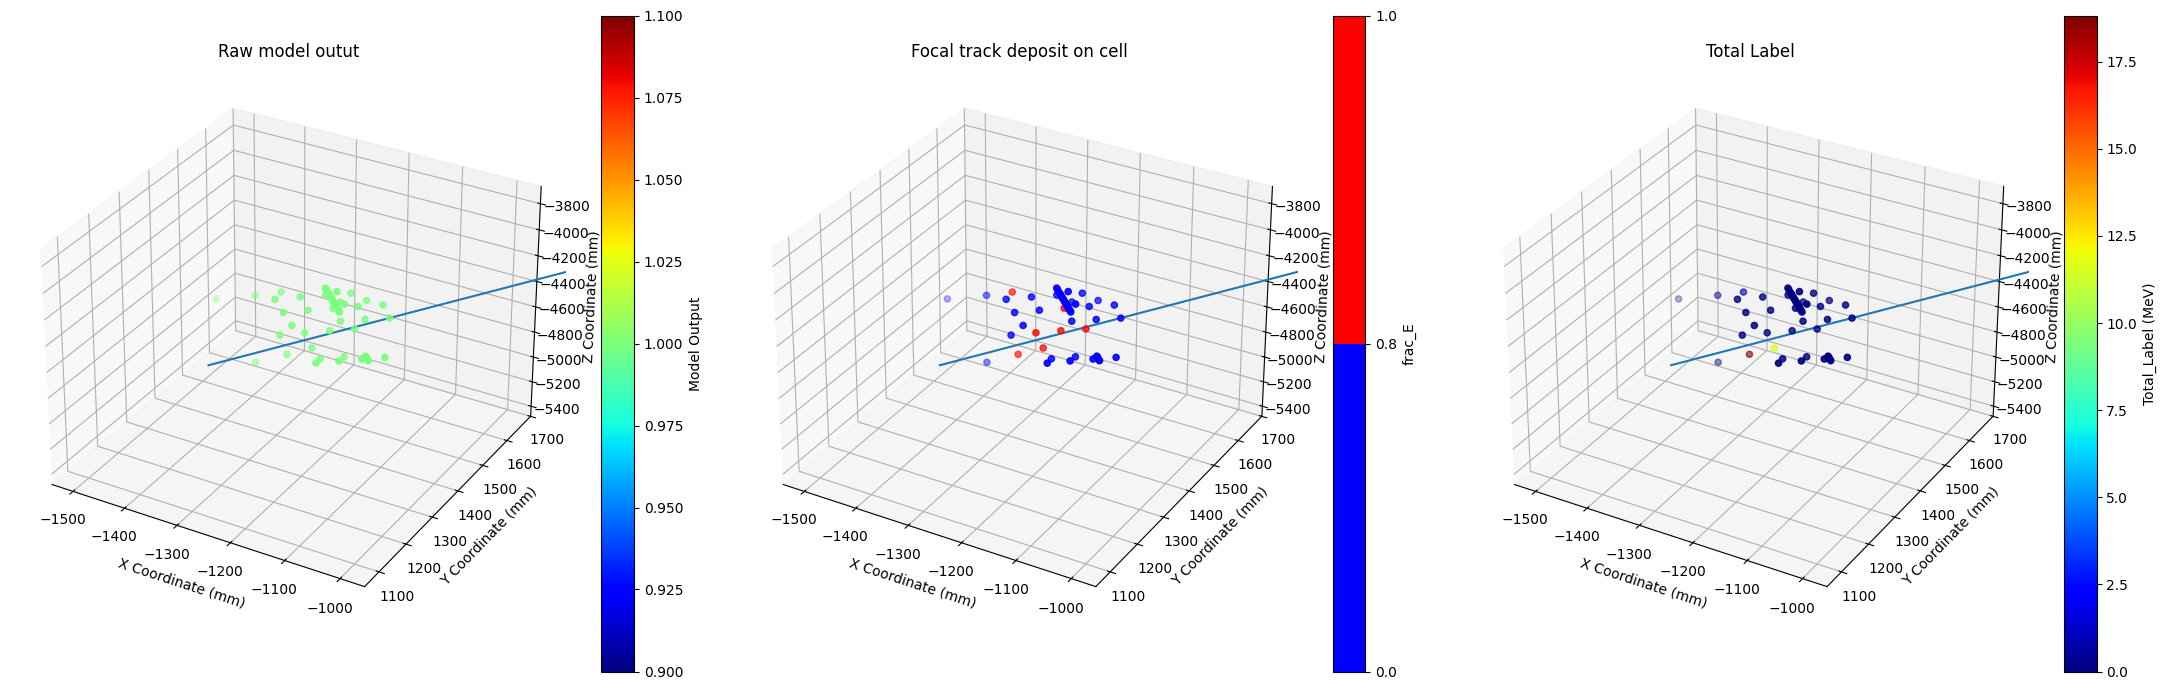

In [21]:

from matplotlib.colors import ListedColormap


name = str(ak_array[0][sample_idx]['track_part_Idx']) # Particle.from_pdgid(ak_array[0][0]['track_part_Idx']).name

xl, yl, zl = [], [], []
for i in ak_array[0][sample_idx]['track_layer_intersections']:
    xl.append(i['X'])
    yl.append(i['Y'])
    zl.append(i['Z'])

print(len(ak_array[0][0]['associated_cells']))
print(len(filtered_predicted_raw))

'Fraction_Label'
'Total_Label'

xs = [j['X'] for j in ak_array[0][sample_idx]['associated_cells']]
ys = [j['Y'] for j in ak_array[0][sample_idx]['associated_cells']]
zs = [j['Z'] for j in ak_array[0][sample_idx]['associated_cells']]

# Assuming filtered_predicted_raw and frac_eng are arrays of the same length as associated_cells
filtered_predicted_raw = np.array(filtered_predicted_raw)
frac_eng = np.array([j['Fraction_Label'] for j in ak_array[0][sample_idx]['associated_cells']])
total_label = np.array([j['Total_Label'] for j in ak_array[0][sample_idx]['associated_cells']])

print(frac_eng)


# Set up the figure and subplots
fig = plt.figure(figsize=(22, 7))
lower = 1
upper = 99
x_range = (np.percentile(xs, lower), np.percentile(xs, upper))
y_range = (np.percentile(ys, lower), np.percentile(ys, upper))
z_range = (np.percentile(zs, lower), np.percentile(zs, upper))

p_raw = [i if i <= 1 else 1 for i in filtered_predicted_raw]

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(xl, yl, zl, label=name)
ax1.set_xlabel('X Coordinate (mm)')
ax1.set_ylabel('Y Coordinate (mm)')
ax1.set_zlabel('Z Coordinate (mm)')
ax1.set_title('Raw model outut')
sc1 = ax1.scatter(xs, ys, zs, c=p_raw, cmap='jet')
cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('Model Output')
ax1.set_xlim(x_range)
ax1.set_ylim(y_range)
ax1.set_zlim(z_range)

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(xl, yl, zl, label=name)
ax2.set_xlabel('X Coordinate (mm)')
ax2.set_ylabel('Y Coordinate (mm)')
ax2.set_zlabel('Z Coordinate (mm)')
ax2.set_title(r'Focal track deposit on cell')
sc2 = ax2.scatter(xs, ys, zs, c=frac_eng, cmap=ListedColormap(['blue', 'red']))
cbar2 = plt.colorbar(sc2, ax=ax2, boundaries=[0, 0.8, 1])
cbar2.set_label('frac_E')
ax2.set_xlim(x_range)
ax2.set_ylim(y_range)
ax2.set_zlim(z_range)

# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(xl, yl, zl, label=name)
ax3.set_xlabel('X Coordinate (mm)')
ax3.set_ylabel('Y Coordinate (mm)')
ax3.set_zlabel('Z Coordinate (mm)')
ax3.set_title('Total Label')
sc3 = ax3.scatter(xs, ys, zs, c=total_label, cmap='jet')
cbar3 = plt.colorbar(sc3, ax=ax3)
cbar3.set_label('Total_Label (MeV)')
ax3.set_xlim(x_range)
ax3.set_ylim(y_range)
ax3.set_zlim(z_range)

# Adjust layout
plt.tight_layout()




In [9]:
predicted_classes_filtered

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

{'val_acc': [0.1372724324464798, 0.14451925456523895, 0.13258187472820282, 0.13528692722320557, 0.1350943148136139, 0.14285030961036682, 0.1426026076078415, 0.14300115406513214, 0.13906827569007874, 0.13518378138542175, 0.1431143581867218, 0.13839313387870789, 0.13528692722320557, 0.12981963157653809, 0.13510984182357788, 0.13541635870933533, 0.1337074637413025, 0.1390707939863205, 0.1372879445552826, 0.13693445920944214, 0.1382260024547577, 0.1345573365688324, 0.13543400168418884, 0.14159874618053436, 0.14127592742443085, 0.13865968585014343, 0.13582520186901093, 0.1390707939863205, 0.1403992474079132, 0.1390707939863205, 0.13675817847251892, 0.14150679111480713, 0.13109003007411957, 0.14204756915569305, 0.13871479034423828, 0.1338239163160324, 0.14013758301734924, 0.13556118309497833, 0.1387667953968048, 0.14120279252529144, 0.13700588047504425, 0.14159874618053436, 0.13873031735420227, 0.13509681820869446, 0.13826344907283783, 0.13409045338630676, 0.14129476249217987, 0.144608736038

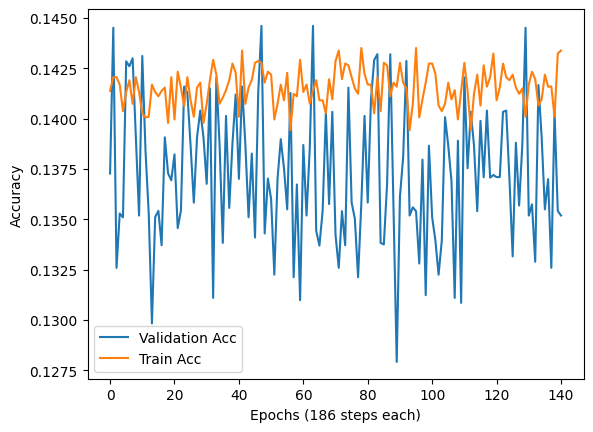

In [10]:
import json

with open("/home/jhimmens/workspace/jetpointnet/models/metadata/metadata.json",'r') as file:
    data = json.load(file)

print(data)
plt.plot(data['val_acc'], label="Validation Acc")
plt.plot(data['train_acc'], label="Train Acc")
plt.ylabel("Accuracy")
plt.xlabel("Epochs (186 steps each)")
plt.legend()
plt.show()

In [11]:
ak_array[0][2]['associated_cells']

<Array [{ID: 763381798, E: 0.044, ...}, ...] type='104 * {ID: int64, E: flo...'>

In [12]:
ak_array[0][3]

<Record {trackID: 3, trackEta: 1.05, ...} type='{trackID: int64, trackEta: ...'>

In [13]:
# is the numpy labeled array and the awk frac energy the same??
ak_array[0][0]['associated_cells'][48]["Fraction_Label"]

0

In [14]:
frac_labels[0][54]

0.0

In [15]:
#create a histogram of fractional energy
simple_frac_all = []
for event in ak_array:
    for track in event:
        for cell in track["associated_cells"]:
            simple_frac_all.append(cell["Fraction_Label"])


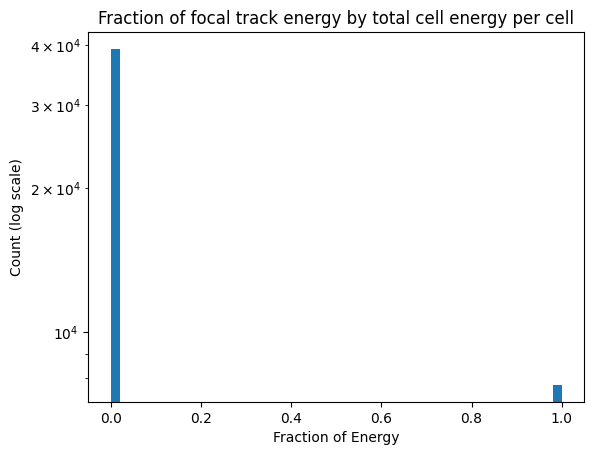

In [16]:
plt.hist(simple_frac_all, bins=50, log=True, range=(0, 1))
plt.yscale('log')

# Labels and title
plt.xlabel('Fraction of Energy')
plt.ylabel('Count (log scale)')
plt.title('Fraction of focal track energy by total cell energy per cell')

# Save the plot to a file
plt.savefig('1d_histogram_log_scale.png', dpi=500)


In [38]:
print(12)

12


In [56]:
import numpy as np

data = np.load("/home/jhimmens/workspace/jetpointnet/pnet_data/processed_files/raw/2000_events_w_fixed_hits/SavedNpz/deltaR=0.1/energy_scale=1000/train/chunk_0_train.npz")

In [3]:
feats = data['feats']
event = feats[0]
track = event[0]
track

(60059010, -1, 1, 0.00540142, 0, 0, 0.841264, 0.05669045, 0.9065134, 0., -1., 2.4929976)

In [57]:

tt = feats[:][:]
tt

array([[(60059010, -1,  1,  5.4014213e-03,  0,  0,  0.841264  ,  0.05669045,  0.9065134 ,  0., -1.,  2.4929976),
        (60059010, -1,  1,  0.0000000e+00,  0,  0,  0.76202506,  0.17514966,  0.7862124 ,  0., -1.,  2.4929976),
        (60059010, -1,  1,  1.6248798e-02,  0,  0,  0.713018  ,  0.30241662,  0.66463876,  0., -1.,  2.4929976),
        ...,
        (      -1, -1, -1, -1.0000000e+00, -1, -1, -1.        , -1.        , -1.        , -1., -1., -1.       ),
        (      -1, -1, -1, -1.0000000e+00, -1, -1, -1.        , -1.        , -1.        , -1., -1., -1.       ),
        (      -1, -1, -1, -1.0000000e+00, -1, -1, -1.        , -1.        , -1.        , -1., -1., -1.       )],
       [(60059010, -1,  3,  1.2079591e-03,  0,  0,  0.9439678 ,  0.04603347,  0.11531422,  0., -1., 17.172144 ),
        (60059010, -1,  3,  0.0000000e+00,  0,  0,  0.85837275,  0.1085092 ,  0.19442642,  0., -1., 17.172144 ),
        (60059010, -1,  3,  4.2655328e-03,  0,  0,  0.7688097 ,  0.16992824,  0.28

In [28]:
np_arr = np.array(test_data, dtype=event_array_dtype)
np_arr

NameError: name 'test_data' is not defined

In [1]:
import tensorflow as tf

2024-06-04 20:27:27.591409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 20:27:30.151006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 20:27:30.156592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 20:27:30.789582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 20:27:31.879634: I tensorflow/core/platform/cpu_feature_guar

In [13]:
dataset = tf.data.Dataset.from_tensor_slices(tt)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy data type).

In [20]:
tensor = tf.convert_to_tensor(tt.view(np.float32))
tensor

<tf.Tensor: shape=(11076, 3336), dtype=float32, numpy=
array([[ 8.723800e-37,           nan,  1.401298e-45, ..., -1.000000e+00,
        -1.000000e+00, -1.000000e+00],
       [ 8.723800e-37,           nan,  4.203895e-45, ..., -1.000000e+00,
        -1.000000e+00, -1.000000e+00],
       [ 8.723800e-37,           nan,  7.006492e-45, ..., -1.000000e+00,
        -1.000000e+00, -1.000000e+00],
       ...,
       [ 8.723802e-37,           nan,  5.044674e-44, ..., -1.000000e+00,
        -1.000000e+00, -1.000000e+00],
       [ 8.723802e-37,           nan,  5.605194e-44, ..., -1.000000e+00,
        -1.000000e+00, -1.000000e+00],
       [ 8.723802e-37,           nan,  7.146622e-44, ..., -1.000000e+00,
        -1.000000e+00, -1.000000e+00]], dtype=float32)>

In [50]:
arr = np.array([(1,2.3,4)], np.dtype([
    ('first', np.float32),
    ('second', np.float32),
    ('third', np.float32),
]))

arr.view(np.float32)

array([1. , 2.3, 4. ], dtype=float32)

In [52]:
from numpy.lib import recfunctions as rfn

In [62]:
tt[0]

array([(60059010,         -1,  1,  0.00540142,  0,  0,  0.841264  ,  0.05669045,  0.9065134 ,  0.        , -1.0000000e+00,  2.4929976),
       (60059010,         -1,  1,  0.        ,  0,  0,  0.76202506,  0.17514966,  0.7862124 ,  0.        , -1.0000000e+00,  2.4929976),
       (60059010,         -1,  1,  0.0162488 ,  0,  0,  0.713018  ,  0.30241662,  0.66463876,  0.        , -1.0000000e+00,  2.4929976),
       (60059010,         -1,  1,  0.0323535 ,  0,  0,  0.5324337 ,  0.6322537 ,  0.3388449 ,  0.        , -1.0000000e+00,  2.4929976),
       (60059010,         -1,  1,  0.03879444,  0,  0,  0.32696825,  0.97095674,  0.        ,  0.        , -1.0000000e+00,  2.4929976),
       (60059010,  754990630, -1,  0.03971255,  1, -1,  0.8132823 ,  0.        ,  0.93311363,  0.30302605,  1.7891774e+02, -1.       ),
       (60059010,  754991142, -1,  0.05512068,  1, -1,  0.8132823 ,  0.        ,  0.8967811 ,  0.28479   ,  4.6198492e+02, -1.       ),
       (60059010,  757198886, -1,  0.0364682 ,  

In [61]:
rfn.structured_to_unstructured(tt)[0]

array([[ 6.00590100e+07, -1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00, -1.00000000e+00,  2.49299765e+00],
       [ 6.00590100e+07, -1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00, -1.00000000e+00,  2.49299765e+00],
       [ 6.00590100e+07, -1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00, -1.00000000e+00,  2.49299765e+00],
       ...,
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]])

In [81]:
bce = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
)
bce([[[1,0,0],[1,1]],[[1,0,0],[1,1,1]]], [[[1,0,1],[1,0.2]],[[1,0,0],[1,1,1]]])

ValueError: Can't convert non-rectangular Python sequence to Tensor.